In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("Recursive least squares.ipynb")

# Matrix Analysis 2024 - EE312
## Week 5  - Recursive least squares
[N. Aspert](https://people.epfl.ch/nicolas.aspert) - [LTS2](https://lts2.epfl.ch)


## Important
- You need to submit *individually* your answers on moodle before the next exercise session. For the theoretical questions you can either fill the notebook or write it on a separate sheet (if you are not comfortable with Markdown/TeX) and upload a scanned version. 
- The unit tests are here to help you, however they might pass even if your implementation is faulty !


## Objective

The goal of this notebook is to find the parameters of a system using least squares, and more specifically use a recursive formulation to update those parameters with a reduced amount of computations.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

## Part I - Least-square parameter estimation

In this notebook, we will estimate physical parameters of a moving system. Its $(x,y)$ coordinates are sampled at regular time intervals, but are noisy (e.g. due to measurement artefacts). You can load them from a file using the code below.

In [6]:
data = np.load('data.npz')

Once loaded, the `data` variable is a dictionary containing 3 arrays:
- `time` for the time values corresponding to each sample
- `tr1` for the first system trajectory
- `tr2` for the second system trajectory

The trajectories are stored as complex numbers to have a single value representing the $x$ and $y$ components. In the first part of the problem we will only use ther data from `tr1`.

Text(0, 0.5, 'y')

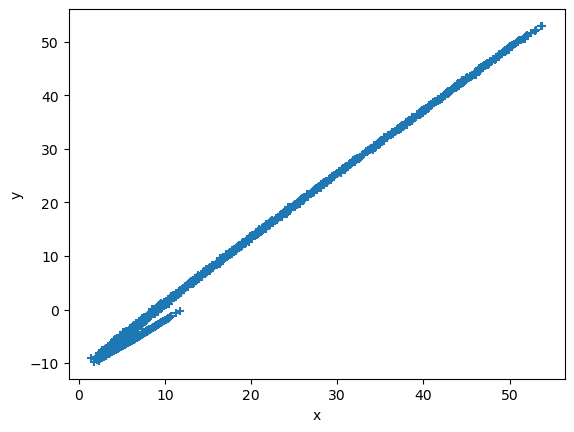

In [7]:
plt.scatter(np.real(data['tr1']), np.imag(data['tr1']), marker='+')
plt.xlabel('x')
plt.ylabel('y')

<!-- BEGIN QUESTION -->

Let us now build the model of this system. In this part we will assume that the system is defined by 3 parameters:
- its initial position $p_0$
- its initial velocity $v_0$
- its acceleration $a$ which is constant

Those parameters will be represented as complex values (in order to take into account their $x$ and $y$ components)

1. Express the position of the system $p(t)$ as a function of $t$ and of the 3 above parameters. 

_Type your answer here, replacing this text._

Using the fact that the acceleration remains constant through time, we can express the instantaneous speed of the system $v(t)$ as
$$
v(t) = v_0 + at
$$

Integrating a second time, this yields
$$
p(t) = p_0 + v_0t+ \frac{1}{2}at^2
$$

<!-- END QUESTION -->

Since we have the whole trajectory of the system and given the relatively small number of samples, we can now estimate directly the 3 parameters using a least-square approximation. 

2. Using the previous question, write a function that generates the matrix $A$ s.t. 
$$
A\begin{pmatrix}p_0 \\ v_0 \\ a\end{pmatrix} = \begin{pmatrix}p(t_0) \\ p(t_1) \\ \vdots \\ p(t_{N-1}) \end{pmatrix} 
$$

In [8]:
def computeA(t):
    """
    Computes the A matrix 

    Parameters
    ----------
    t : vector containing values of time samples
   
    Returns
    -------
    The A matrix 
    """
    # BEGIN SOLUTION
    N = len(t)
    A = np.ones((N, 3))
    A[:, 1] = t
    A[:, 2] = 0.5*t*t
    return A
    # END SOLUTION

In [ ]:
grader.check("q2")

3. Estimate the parameters of the system using a least square approximation

In [10]:
def solve_lsq(t, pos):
    """
    Solve the system Ax = pos, where x is the vector (p_0, v_0, a) and pos contains the position values at time t

    Parameters
    ----------
    t : vector containing values of time samples
    pos: vector containing the positions of the system corresponding to the values of t (complex)

   
    Returns
    -------
    The vector x containing the approximation of the system's parameters in the least-square sense.
    """
    # BEGIN SOLUTION
    N = len(t)
    A = computeA(t)
    return np.linalg.inv(A.T@A)@A.T@pos
    # END SOLUTION

In [ ]:
grader.check("q3")

<!-- BEGIN QUESTION -->

4. Display the measured trajectory `tr1` and the one reconstructed from the parameters you estimated. If your implementation is correct, they should match. Also plot the euclidean distance between the measured and reconstructed point fo each timestep.

_Type your answer here, replacing this text._

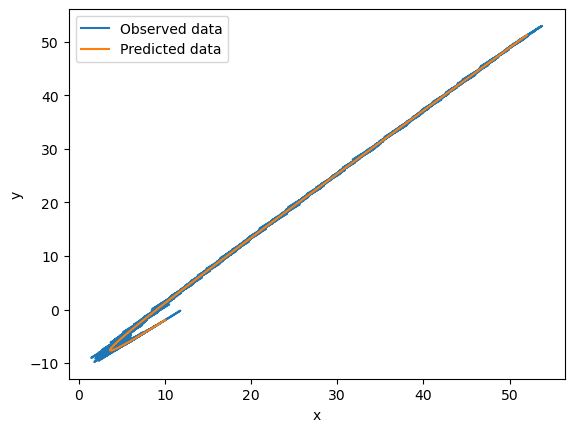

In [12]:
# Plot the observed and predicted data
# BEGIN SOLUTION
A = computeA(data['time'])
x = solve_lsq(data['time'], data['tr1'])
recPos = A@x
plt.plot(np.real(data['tr1']), np.imag(data['tr1']), label='Observed data')
plt.plot(np.real(recPos), np.imag(recPos), label='Predicted data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
# END SOLUTION

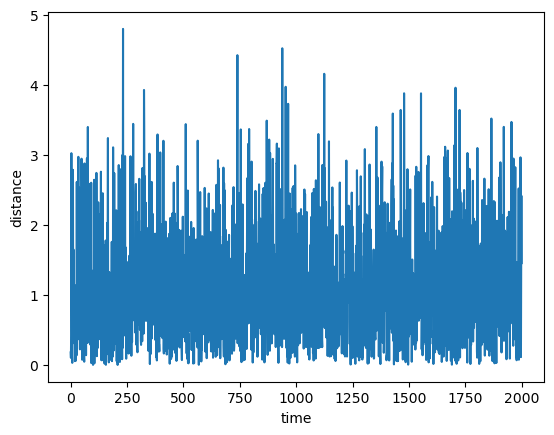

In [13]:
# Plot the distance between each point
# BEGIN SOLUTION
plt.plot(np.abs(data['tr1']-recPos))
plt.xlabel('time')
plt.ylabel('distance')
plt.show()
# END SOLUTION

We can see that the error remains small and that the model fits the experimental data.

<!-- END QUESTION -->

## Part II - Recursive least-square estimation

The problem addressed in the first part was fairly easy: we had all measurements available at once (which is fine in an "offline" setting), and computing the least-square solution did not require to invert a huge matrix. In a more realistic setting, the measurements would come gradually and it would be nice to update our parameters without recomputing the whole solution at each step. This is where recursive least-squares come into place.


<!-- BEGIN QUESTION -->

We first need to prove a classical result. Let us consider four matrices $A,B,C$ and $D$ such that:
- $A$ is an invertible $N\times N$ matrix
- $B$ is a $N\times M$ matrix 
- $C$ is $M\times N$ matrix
- $D$ is an invertible $M\times M$ matrix

5. Prove that $(A + BDC)^{-1} = A^{-1} - A^{-1}B(D^{-1}+CA^{-1}B)^{-1}CA^{-1}$


_Type your answer here, replacing this text._

This is the **matrix inversion lemma**, also called **Sherman-Woodbury-Morrison formula**. There are several ways of proving the result. 

We can simply develop the expression $(A + BDC)(A^{-1} - A^{-1}B(D^{-1}+CA^{-1}B)^{-1}CA^{-1})$ which gives the following terms:

$\begin{align}
&= AA^{-1} + BDCA^{-1} - AA^{-1}B(D^{-1}+CA^{-1}B)^{-1}CA^{-1}) - BDCA^{-1}B(D^{-1}+CA^{-1}B)^{-1}CA^{-1}) \\
&= I +  BDCA^{-1} - (B + BDCA^{-1}B)(D^{-1}+CA^{-1}B)^{-1}CA^{-1}
\end{align}$

Since D is invertible, we can rewrite this as:

$\begin{align}
&= I +  BDCA^{-1} - BD(D^{-1} + CA^{-1}B)(D^{-1}+CA^{-1}B)^{-1}CA^{-1} \\
&= I +  BDCA^{-1} - +  BDCA^{-1}\\
&= I
\end{align}$

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Let us consider the least-square problem $Ax=y$, and suppose we already have received a small (but still keeping the system over-determined) number of measurements $y_0$ and computed $\hat{x}_0$ that is the least-square solution of $A_0\hat{x}_0=y_0$. Let us assume we have already computed $Q_0=(A_0^TA_0)^{-1}$.

Now another set of measurements $y_1$ arrives, and the system you want to solve looks like
$$
\begin{pmatrix}A_0\\A_1\end{pmatrix}x = \begin{pmatrix}y_0\\y_1\end{pmatrix} 
$$

6. Using this block matrix formulation, rewrite the normal equation and express the updated solution $\hat{x}_1$ using $A_0$, $A_1$, $Q_0^{-1}$, $\hat{x}_0$, and $y_1$. 

Let us denote by $Q_1 = (A_0^TA_0 + A_1^TA_1)^{-1}$. Express $\hat{x}_1$ as a function of $Q_1$, $A_1$, $y1$ and $\hat{x}_0$. 

_Type your answer here, replacing this text._

We multiply both sides by $A^T$, which gives:

$$
\begin{pmatrix}A_0^T & A_1^T\end{pmatrix}\begin{pmatrix}A_0\\A_1\end{pmatrix}x = \begin{pmatrix}A_0^T & A_1^T\end{pmatrix}\begin{pmatrix}y_0\\y_1\end{pmatrix} 
$$

If we develop, this gives the following problem to solve:
$$
(A_0^TA_0 + A_1^TA_1)x = (A_0^Ty_0 + A_1^Ty1)
$$

This is just a different way of writing the normal equation, which gives:
$$
\hat{x}_1=(A_0^TA_0 + A_1^TA_1)^{-1}(A_0^Ty_0 + A_1^Ty1)
$$

Using the initial least square solution, we have $\hat{x}_0=Q_0A_0^Ty_0$, or $Q_0^{-1}\hat{x}_0=A_0^Ty_0$, and thus:
$$
\hat{x}_1=(A_0^TA_0 + A_1^TA_1)^{-1}(Q_0^{-1}\hat{x}_0 + A_1^Ty1)
$$

Using the definition of $Q_1$, we see that $Q_0^{-1} = Q_1^{-1} - A_1^TA_1$. 

Introducing this in the previous result gives

$\begin{align}
\hat{x}_1 &= Q_1(Q_1^{-1}\hat{x}_0 - A_1^TA_1\hat{x}_0 + A_1^Ty_1)\\
&= \hat{x}_0 + Q_1A_1^T(y_1 - A_1\hat{x}_0)
\end{align}$

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Using the result shown in question 5, express $Q_1$ as a function of $Q_0$, $A_1$ and $U=Q_0A_1^T$. 

Hints:
- you might consider $Q_1^{-1}$
- what about $Q_0$ symmetry ?


Why is it interesting to update the system's parameters by computing $Q_1$ this way ?

_Type your answer here, replacing this text._

We have $Q_1^{-1} = Q_0^{-1} + A_1^TA_1$. This resembles the result we proved in question 5 by setting $D=I$, $B=A_1^T$ and $C=A_1$. Therefore using the matrix inversion lemma we have 
$$
Q_1 = Q_0 - Q_0A_1^T(I + A_1Q_0A_1^T)^{-1}A_1Q_0
$$

Remarking that $Q_0 = Q_0^T$, we can use $U=Q_0A_1^T$ to write this as
$$
Q_1 = Q_0 - U(I + A_1U)^{-1}U^T
$$

First, it is clear that the steps above can be repeated when a new batch of measurement arrives. $Q_{n+1}$ can be computed from $Q_n$ and $A_{n+1}$, and the updated solution $\hat{x}_{n+1}$ can be computed using $Q_{n+1}$, $A_{n+1}$ and $\hat{x}_n$.

Moreover, we see in this result that, provided $Q_0$ has been computed (and is a reather small matrix to invert), $Q_1$ can be computed by inverting $(I + A_1Q_0A_1^T)$. $Q_0$ is a $n \times n$ matrix (where $n$ is the number of parameters of our model), $A_1$ is a $M\times n$ matrix, where $M \gg n$ but smaller than the total number of measurements we will process overall. Matrix inversion being (roughly) $O(M^3)$, this method keeps computational complexity to a constant level for each batch of new measurements. This also reduces the memory requirements as we do not need to handle a growing matrix $A$ for the system as new measurements arrive.

<!-- END QUESTION -->

8. Using the results of questions 6 and 7, implement a function that computes the updated parameters for a new set of measurements and complete the `recursive_lsq`implementation.

In [14]:
def update_lsq(Q0, xhat0, meas_time, y1):
    """
    Compute the updated parameters xhat1 from Q0, y1, xhat0

    Parameters
    ----------
    Q0 : matrix Q0
    xhat0: previously computed parameters of the system
    meas_time: vector containing the times at which samples were acquired
    y1: vector containing the new positions of the system corresponding to the values of meas_time
   
    Returns
    -------
    xhat1 and Q1 
    """
    # BEGIN SOLUTION
    batch_size = len(y1)
    A1 = computeA(meas_time)
    U = Q0@A1.T
    Q1 = Q0 - U@np.linalg.inv((np.eye(batch_size) + A1@U))@U.T
    xhat1 = xhat0 + Q1@A1.T@(y1 - A1@xhat0)
    return xhat1, Q1
    # END SOLUTION

In [15]:
def recursive_lsq(t, pos, batch_size):
    """
    Perform recursive LSQ fit on iput data splitted in batches

    Parameters
    ----------
    t: vector containing values of time samples
    pos: vector containing the positions of the system corresponding to the values of t (complex)
    batch_size: size of each batch of measurements
    
    Returns
    -------
    array containing model parameters estimated after each batch
    """
    
    if batch_size < 2:
        raise ValueError("Invalid batch size")
        
    nsteps = len(t)//batch_size

    # initialization step
    A0 =computeA(t[:batch_size])
    Q0 = np.linalg.inv(A0.T@A0)
    
    xhat0 = Q0@A0.T@pos[:batch_size] # SOLUTION
    xh_cur = xhat0
    Q_cur = Q0
    x_h = [xhat0] # store the history of parameters in a list
    for k in np.arange(1, nsteps):
        cur_time = t[k*batch_size:(k+1)*batch_size]
        cur_pos = pos[k*batch_size:(k+1)*batch_size]
        xhat1, Q1 = update_lsq(Q_cur, xh_cur, cur_time, cur_pos) # SOLUTION
        x_h.append(xhat1)
        xh_cur = xhat1
        Q_cur = Q1
    return np.array(x_h)
        

In [ ]:
grader.check("q8")

<!-- BEGIN QUESTION -->

9. Complete the `predict_trajectory` function, and the `tr1` data:
- display the predicted trajectory of the system when using recursive least-squares
- display the distance between the predicted and observed trajectory
Make sure to chose a suitable batch size.

In [17]:
def predict_trajectory(x_h, t, pos, batch_size):
    pos_pred = np.zeros(pos.shape, dtype='complex')
    # Initialization
    pos_pred[:batch_size] = pos[:batch_size]
    for k in np.arange(1, len(x_h)):
        A1 = computeA(t[k*batch_size:(k+1)*batch_size])
        pos_pred[k*batch_size:(k + 1)*batch_size] = A1@x_h[k-1] # SOLUTION
    return pos_pred

In [18]:
batch_size = 20 # SOLUTION

In [19]:
x_h = recursive_lsq(data['time'], data['tr1'], batch_size) # SOLUTION

In [20]:
pred_traj = predict_trajectory(x_h, data['time'], data['tr1'], batch_size) # SOLUTION

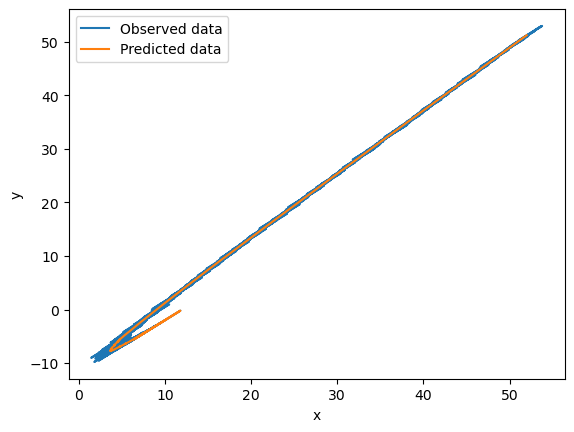

In [21]:
# Plot the predicted and observed data
# BEGIN SOLUTION
plt.plot(np.real(data['tr1']), np.imag(data['tr1']), label='Observed data')
plt.plot(np.real(pred_traj), np.imag(pred_traj), label='Predicted data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
# END SOLUTION

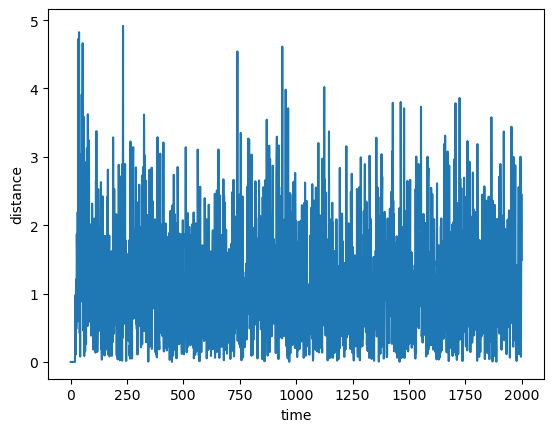

In [22]:
# Plot the error between prediction and observation
# BEGIN SOLUTION
plt.plot(np.abs(data['tr1']-pred_traj))
plt.xlabel('time')
plt.ylabel('distance')
plt.show()
# END SOLUTION

<!-- END QUESTION -->

## Part III - Recursive least square with forgetting factor



<!-- BEGIN QUESTION -->

10. Use the recursive least square on the `tr2` trajectory, whose acceleration varies across time. Display the predicted trajectory and approximation error. Is that what you expected ?

_Type your answer here, replacing this text._

In [23]:
x2_h = recursive_lsq(data['time'], data['tr2'], batch_size) # SOLUTION

In [24]:
pred_traj2 = predict_trajectory(x2_h, data['time'], data['tr2'], batch_size) # SOLUTION

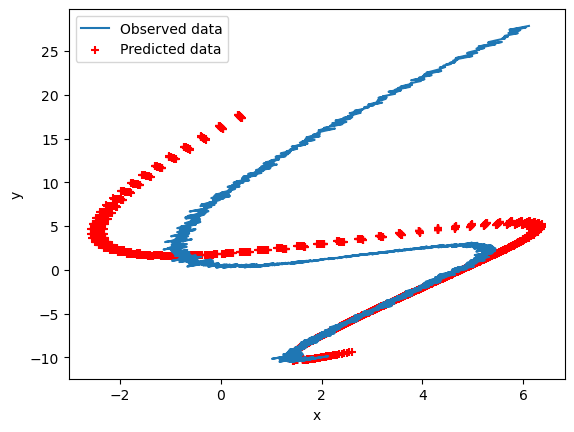

In [25]:
# Plot the predicted and observed data
# BEGIN SOLUTION
plt.plot(np.real(data['tr2']), np.imag(data['tr2']), label='Observed data')
plt.scatter(np.real(pred_traj2), np.imag(pred_traj2), marker='+', color='r', label='Predicted data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
# END SOLUTION

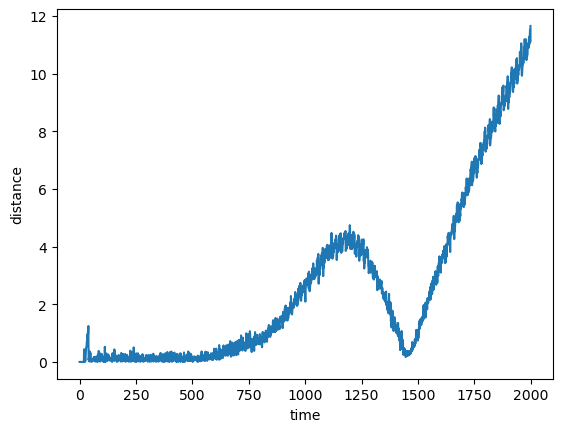

In [26]:
# Plot the error between prediction and observation
# BEGIN SOLUTION
plt.plot(np.abs(data['tr2']-pred_traj2))
plt.xlabel('time')
plt.ylabel('distance')
plt.show()
# END SOLUTION

As expected, our acceleration constant model struggles to follow the actual trajectory. Parameter estimation sorts of follow the trend but is not really good, and the error grows at each acceleration change.

<!-- END QUESTION -->

In order to solve this issue, we could either build a more complex model. However, making the assumption that the acceleration changes infrequently, we can try to update the recursive least-square in a way that will give higher importance to the recent measurements with respect to older ones. In order to do so, we will introduce a **forgetting factor** $\alpha$, with $0<\alpha<1$.

We will use this as follows:
When another set of measurements $y_1$ arrives, and the system defined in question 6 will be rewritten as
$$
\begin{pmatrix}\alpha A_0\\A_1\end{pmatrix}x = \begin{pmatrix}\alpha y_0\\y_1\end{pmatrix} 
$$

<!-- BEGIN QUESTION -->

11. Using the new "forgetful" system defined above, update the expressions $Q_1$ and $\hat{x}_1$ derived in questions 6 and 7

Hint:  
- You might want to introduce $U_\alpha = \frac{1}{\alpha} Q_0A_1^T$,

_Type your answer here, replacing this text._

If we develop the expression as in question 6 we get

$$
(\alpha^2 A_0^TA_0 + A_1^TA_1)x = (\alpha^2 A_0^Ty_0 +  A_1^Ty1)
$$

Therefore $Q_1$ becomes $(\alpha^2 A_0^TA_0 + A_1^TA_1)^{-1} = \frac{1}{\alpha^2}(Q_0^{-1} + \frac{1}{\alpha^2} A_1^TA_1)^{-1}$. Using again the matrix inversion lemma with $B=\frac{1}{\alpha} A_1^T$ and $C=\frac{1}{\alpha} A_1$, we get

$$
Q_1 = \frac{1}{\alpha^2}(Q_0 - \frac{1}{\alpha^2} Q_0A_1^T(I + \frac{1}{\alpha^2} A_1Q_0A_1^T)^{-1}A_1Q_0)
$$

If we introduce $U_\alpha=\frac{1}{\alpha} Q_0A_1^T$ this becomes
$$
Q_1 = \frac{1}{\alpha^2}(Q_0 -  U_\alpha(I + \frac{1}{\alpha} A_1U_\alpha)^{-1}U_\alpha^T)
$$

We can then update $\hat{x}_1$:

$\hat{x}_1 = Q_1(\alpha^2 A_0^Ty_0 + A_1^Ty_1) = Q_1(\alpha^2 Q_0^{-1}\hat{x}_0 + A_1^Ty_1)$

Noticing that $Q_0^{-1} = \frac{1}{\alpha^2}(Q_1^{-1} - A_1^TA_1)$ and expanding this we get:

$\hat{x}_1 = Q_1(Q_1^{-1}\hat{x}_0 - A_1^TA_1\hat{x}_0 + A_1^Ty_1) = \hat{x}_0 - Q_1A_1^T(y_1 -  A_1\hat{x}_0)$ which is identical to the one obtained in the previous question.

<!-- END QUESTION -->

12. Using the results found at the previous question, implement the recursive least square with a forgetting factor.

In [27]:
def update_lsq_ff(Q0, xhat0, meas_time, y1, ff):
    """
    Compute the updated parameters xhat1 from Q0, y1, xhat0, ff

    Parameters
    ----------
    Q0 : matrix Q0
    xhat0: previously computed parameters of the system
    meas_time: vector containing the times at which samples were acquired
    y1: vector containing the new positions of the system corresponding to the values of meas_time
    ff: forgetting factor 
   
    Returns
    -------
    xhat1 and Q1 
    """
    # BEGIN SOLUTION
    batch_size = len(y1)
    A1 = computeA(meas_time)
    U = Q0@A1.T/ff
    Q1 = (Q0 - U@np.linalg.inv((np.eye(batch_size) + A1@U/ff))@U.T)/(ff*ff)
    xhat1 = xhat0 + Q1@A1.T@(y1 - A1@xhat0)
    return xhat1, Q1
    # END SOLUTION

In [28]:
def recursive_lsq_ff(t, pos, batch_size, ff):
    """
    Perform recursive LSQ fit on iput data splitted in batches

    Parameters
    ----------
    t: vector containing values of time samples
    pos: vector containing the positions of the system corresponding to the values of t (complex)
    batch_size: size of each batch of measurements
    ff: forgetting factor (in practice, keep it close to 1)
    
    Returns
    -------
    array containing model parameters estimated after each batch
    """
    
    if batch_size < 2:
        raise ValueError("Invalid batch size")
        
    nsteps = len(t)//batch_size

    # initialization step
    A0 = computeA(t[:batch_size])
    Q0 = np.linalg.inv(A0.T@A0)
    
    xhat0 = Q0@A0.T@pos[:batch_size] # SOLUTION
    xh_cur = xhat0
    Q_cur = Q0
    x_h = [xhat0] # store the history of parameters in a list
    for k in np.arange(1, nsteps):
        cur_time = t[k*batch_size:(k+1)*batch_size]
        cur_pos = pos[k*batch_size:(k+1)*batch_size]
        xhat1, Q1 = update_lsq_ff(Q_cur, xh_cur, cur_time, cur_pos, ff) # SOLUTION
        x_h.append(xhat1)
        xh_cur = xhat1
        Q_cur = Q1
    return np.array(x_h)

In [ ]:
grader.check("q12")

<!-- BEGIN QUESTION -->

13. Use the functions defined at question 12 to predict `tr2` trajectory. Adjust the batch size and forgetting factor (hint: keep it close to 1) to improve results. Display the predicted trajectory and observed one, and also the evolution of the prediction error across time.

_Type your answer here, replacing this text._

In [42]:
ff = 0.92 # SOLUTION

In [43]:
batch_size = 20 # SOLUTION

In [44]:
x2_h_ff = recursive_lsq_ff(data['time'], data['tr2'], batch_size, ff) # SOLUTION

In [45]:
pred_traj2_ff = predict_trajectory(x2_h_ff, data['time'], data['tr2'], batch_size) # SOLUTION

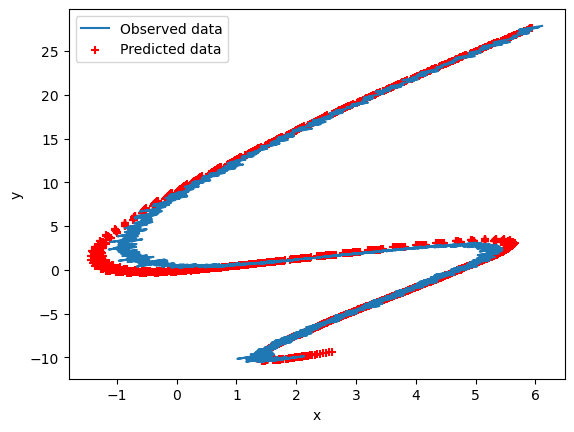

In [46]:
# Plot the predicted and observed data
# BEGIN SOLUTION
plt.plot(np.real(data['tr2']), np.imag(data['tr2']), label='Observed data')
plt.scatter(np.real(pred_traj2_ff), np.imag(pred_traj2_ff), marker='+', color='r', label='Predicted data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
# END SOLUTION

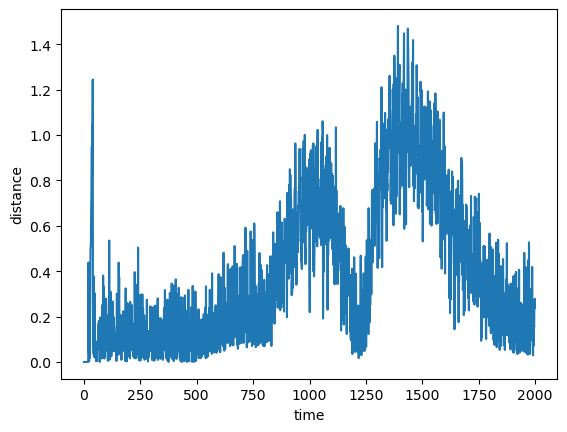

In [47]:
# Plot the error between prediction and observation
# BEGIN SOLUTION
plt.plot(np.abs(data['tr2']-pred_traj2_ff))
plt.xlabel('time')
plt.ylabel('distance')
plt.show()
# END SOLUTION

If we remember the prediction error achieved with the non-forgetting version, this is much better !

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Upload your notebook and separate pdf for theoretical questions if needed

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)